# Single Shot Multibox Detection

I was having difficulties with RandomIoUCrop, It wasn't working great for various reasons. The parameters I had initially: (min_scale=0.6, sampler_options=(0.5, 0.7, 0.9), aspect ratio between 0.5–2.0) didn't work because the pedestrians were too small and skinny to satisfy the IoU constraints. Requiring an IoU >= 0.9 with a crop that covers at least 60% of the image is pretty much impossible when each person covers only 20% of the frame. Because RandomIoUCrop kept trying to find a valid crop, it would get stuck in an infinite loop for some images. I tried multiple things, like giving sampler_option the option to pick 0.0, reducing min_scale, and widening the aspect ratio bounds. That fixed the infinite search, but the resulting crops were garbage, there were images that had people centered with no GT boxes, or there were crops of just background. I don't think RandomIoUCrop is ideal for Penn-Fudan. I still wanted to include cropping, so I asked Chat GPT to create a custom class that centers crops around a GT box.

There were many errors once again, when multiple people were present, non-target individuals were often removed if they weren’t sufficiently visible. Sometimes all boxes were dropped, leaving an image of a person but no associated GT box. The fix was to add a safety net in \__getitem__ which ensured that if all boxes are dropped after augmentation, the image falls back to no cropping, or at least preserves the largest original box. With this, the pipeline avoids infinite loops, keeps at least one valid GT, and has high quality crops.

In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.ops import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms import v2 as T
from torch import nn, optim

def _area_xyxy(b):
    return (b[:,2]-b[:,0]).clamp(0) * (b[:,3]-b[:,1]).clamp(0)

def _clip_to_canvas(boxes, H, W):
    x1 = boxes[:,0].clamp(0, W-1)
    y1 = boxes[:,1].clamp(0, H-1)
    x2 = boxes[:,2].clamp(0, W-1)
    y2 = boxes[:,3].clamp(0, H-1)
    # ensure x2>=x1, y2>=y1 after clamp
    x2 = torch.maximum(x2, x1)
    y2 = torch.maximum(y2, y1)
    return torch.stack([x1,y1,x2,y2], dim=1)

class SafeBoxCenteredCrop(nn.Module):
    """
    Object-centric crop around a randomly chosen GT box,
    with visibility/AR/scale checks and bounded retries.
    """
    def __init__(
        self,
        out_size=(300,300),
        context=(1.2, 2.0),           # crop size = context * target box size
        scale_img=(0.3, 1.0),         # crop area as fraction of image area (feasibility guard)
        ratio=(0.6, 1.8),             # crop aspect ratio bounds (w/h)
        max_trials=30,
        target_vis_thresh=0.7,        # target box must be at least 70% visible
        keep_vis_thresh=0.5,          # other boxes kept if ≥50% visible
        antialias=True
    ):
        super().__init__()
        self.out_size = out_size
        self.context = context
        self.scale_img = scale_img
        self.ratio = ratio
        self.max_trials = max_trials
        self.target_vis_thresh = target_vis_thresh
        self.keep_vis_thresh = keep_vis_thresh
        self.antialias = antialias

    def forward(self, sample):
        img: tv_tensors.Image = sample["image"]
        boxes: tv_tensors.BoundingBoxes = sample["boxes"]
        labels: torch.Tensor = sample["labels"]

        C, H, W = img.shape
        if boxes.numel() == 0:
            # no boxes --> fallback to simple resize
            return T.Resize(self.out_size, antialias=self.antialias)(sample)

        img_area = float(H * W)
        b = boxes.as_subclass(torch.Tensor)  # (N,4) float xyxy
        areas = _area_xyxy(b)
        # pick a target box proportional to sqrt(area) to bias toward larger persons
        weights = (areas.clamp(min=1)).sqrt()
        tidx = torch.multinomial(weights, 1).item()

        for _ in range(self.max_trials):
            tb = b[tidx]  # target box
            bw = (tb[2]-tb[0]).item()
            bh = (tb[3]-tb[1]).item()
            if bw < 1 or bh < 1:
                continue

            # sample context scale
            s = torch.empty(1).uniform_(*self.context).item()
            crop_w = max(1.0, s * bw)
            crop_h = max(1.0, s * bh)

            ar_min, ar_max = self.ratio
            # adjust width/height to satisfy aspect ratio softly
            ar = crop_w / crop_h
            if ar < ar_min:
                crop_w = ar_min * crop_h
            elif ar > ar_max:
                crop_h = crop_w / ar_max

            # make sure crop area is not absurd vs image
            crop_area = crop_w * crop_h
            if not (self.scale_img[0]*img_area <= crop_area <= self.scale_img[1]*img_area):
                # rescale to nearest bound
                target_area = min(max(crop_area, self.scale_img[0]*img_area), self.scale_img[1]*img_area)
                scale = (target_area / (crop_w*crop_h))**0.5
                crop_w *= scale
                crop_h *= scale

            # choose crop center near target box center with some jitter
            cx = (tb[0] + tb[2]) / 2
            cy = (tb[1] + tb[3]) / 2
            jx = (torch.randn(1).item() * 0.15) * bw  # 15% bw jitter
            jy = (torch.randn(1).item() * 0.15) * bh  # 15% bh jitter
            cx = (cx + jx).clamp(0, W-1)
            cy = (cy + jy).clamp(0, H-1)

            x1 = (cx - crop_w/2); y1 = (cy - crop_h/2)
            x2 = (cx + crop_w/2); y2 = (cy + crop_h/2)

            crop = torch.tensor([[x1,y1,x2,y2]], dtype=b.dtype, device=b.device)
            crop = _clip_to_canvas(crop, H, W)[0]

            # compute visibility of each box inside crop
            inter = torch.stack([
                torch.maximum(b[:,0], crop[0]),
                torch.maximum(b[:,1], crop[1]),
                torch.minimum(b[:,2], crop[2]),
                torch.minimum(b[:,3], crop[3]),
            ], dim=1)
            inter = _clip_to_canvas(inter, H, W)
            inter_area = _area_xyxy(inter)
            box_area = _area_xyxy(b).clamp(min=1)
            vis_frac = (inter_area / box_area)  # per-box visible fraction

            # require target box visibility
            if vis_frac[tidx].item() < self.target_vis_thresh:
                continue

            # keep boxes with enough visibility
            keep = vis_frac >= self.keep_vis_thresh
            if keep.sum() == 0:
                continue

            # translate+clip kept boxes to crop frame
            kb = b[keep].clone()
            kb[:,0::2] = kb[:,0::2].clamp(crop[0], crop[2]) - crop[0]
            kb[:,1::2] = kb[:,1::2].clamp(crop[1], crop[3]) - crop[1]

            # apply crop to image
            x1i, y1i, x2i, y2i = crop.tolist()
            x1i, y1i, x2i, y2i = int(x1i), int(y1i), int(x2i), int(y2i)
            img_c = img[:, y1i:y2i, x1i:x2i]

            # resize to output
            resize = T.Resize(self.out_size, antialias=self.antialias)
            img_c = resize(tv_tensors.Image(img_c))
            # resize boxes accordingly
            inH, inW = y2i - y1i, x2i - x1i
            scale_x = self.out_size[1] / max(1, inW)
            scale_y = self.out_size[0] / max(1, inH)
            kb[:, [0,2]] *= scale_x
            kb[:, [1,3]] *= scale_y

            out = {
                "image": img_c,
                "boxes": tv_tensors.BoundingBoxes(
                    kb, format=tv_tensors.BoundingBoxFormat.XYXY, canvas_size=self.out_size
                ),
                "labels": labels[keep],
            }
            return out

        # Fallback if no candidate passed quality in max_trials
        fallback = T.Compose([
            T.RandomResizedCrop(size=self.out_size, scale=(0.8,1.0), ratio=(0.75,1.5), antialias=True)
        ])
        out = fallback({"image": img, "boxes": boxes, "labels": labels})
        return out

In [5]:
class PennFudan(Dataset):
    def __init__(self, root, train=True):
        self.root = root
        self.imgs  = sorted(os.listdir(os.path.join(root, "PNGImages")))
        self.masks = sorted(os.listdir(os.path.join(root, "PedMasks")))
        # SSD pipeline: photometric --> geometric --> bbox cleanup --> float
        if train:
            self.tf = T.Compose([
                T.ToImage(),
                T.RandomPhotometricDistort(),
                T.RandomChoice([
                    SafeBoxCenteredCrop(out_size=(300,300),
                                        context=(1.3, 2.2),
                                        scale_img=(0.25, 0.95),
                                        ratio=(0.6, 1.8),
                                        max_trials=30,
                                        target_vis_thresh=0.7,
                                        keep_vis_thresh=0.5),
                    T.RandomResizedCrop(size=(300,300), scale=(0.85,1.0), ratio=(0.75,1.5), antialias=True),
                    T.Identity(),
                ], p=[0.5, 0.3, 0.2]),
                T.RandomHorizontalFlip(p=0.5),
                T.Resize((300, 300), antialias=True),
                T.SanitizeBoundingBoxes(min_size=1),
                T.ToDtype(torch.float32, scale=True),
            ])

            # Fallback
            self.tf_without_crop = T.Compose([
                T.ToImage(),
                T.RandomPhotometricDistort(),
                T.RandomHorizontalFlip(p=0.5),
                T.Resize((300, 300), antialias=True),
                T.SanitizeBoundingBoxes(min_size=1),
                T.ToDtype(torch.float32, scale=True),
            ])
        else:
            self.tf = T.Compose([
                T.ToImage(),
                T.Resize((300, 300), antialias=True),
                T.SanitizeBoundingBoxes(min_size=1),
                T.ToDtype(torch.float32, scale=True),
            ])

    def __len__(self): 
        return len(self.imgs)

    def __getitem__(self, idx):
        ip = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mp = os.path.join(self.root, "PedMasks",  self.masks[idx])

        img  = read_image(ip)                  # (3,H,W), uint8
        mask = read_image(mp)[0]               # (H,W), instance ids
        ids  = torch.unique(mask)[1:]          # drop background=0
        masks = (mask[None] == ids[:, None, None]).to(torch.uint8)  # (N,H,W)
        boxes = masks_to_boxes(masks)          # (N,4) xyxy on original size
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        img = tv_tensors.Image(img)
        boxes = tv_tensors.BoundingBoxes(
            boxes, format=tv_tensors.BoundingBoxFormat.XYXY,
            canvas_size=img.shape[-2:]
        )

        sample = {"image": img, "boxes": boxes, "labels": labels}
        sample = self.tf(sample)

        def _clamp_and_filter(s):
            img = s["image"]
            H, W = img.shape[-2:]
            b = s["boxes"].to(torch.float32)
            b[:, [0,2]] = b[:, [0,2]].clamp(0, W-1)
            b[:, [1,3]] = b[:, [1,3]].clamp(0, H-1)
            w = (b[:,2]-b[:,0]); h = (b[:,3]-b[:,1])
            keep = (w >= 1) & (h >= 1)
            s["boxes"]  = b[keep]
            s["labels"] = s["labels"][keep]
            return s

        sample = _clamp_and_filter(sample)

        # If no GT boxes survive
        if sample["boxes"].numel() == 0:
            if hasattr(self, "tf_without_crop"):
                sample = self.tf_without_crop({"image": img, "boxes": boxes, "labels": labels})
                sample = _clamp_and_filter(sample)

            if sample["boxes"].numel() == 0:
                areas = (boxes[:,2]-boxes[:,0]) * (boxes[:,3]-boxes[:,1])
                k = torch.argmax(areas)
                sample["boxes"]  = boxes[k:k+1].to(torch.float32)
                sample["labels"] = labels[k:k+1]

        out = {
            "boxes":  torch.as_tensor(sample["boxes"], dtype=torch.float32),
            "labels": sample["labels"]
        }
        return sample["image"], out


def collate(batch):
    imgs, targets = list(zip(*batch))
    return torch.stack(imgs, 0), list(targets)

root = "PennFudanPed"
train_ds = PennFudan(root, train=True)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,
                          num_workers=0, collate_fn=collate)


In [ ]:
from torchvision.utils import draw_bounding_boxes, make_grid
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

imgs = []

for i in range(60):
    img, label = train_ds[i]

    img_uint8 = (img * 255).to(torch.uint8)  
    out = draw_bounding_boxes(img_uint8, label["boxes"], colors="red", width=2)

    imgs.append(out)

grid = make_grid(imgs, nrow=5)
pil_grid = TF.to_pil_image(grid)

plt.figure(figsize=(10, 6))
plt.imshow(pil_grid)
plt.axis("off")
plt.show()

![Images](figures/images.png)

In [6]:
from torchvision.models import resnet34, ResNet34_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = resnet34(weights="IMAGENET1K_V1").to(device).eval()

In [5]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


### Original Architecture

| Stage    | Operation                        | Output Shape (C × H × W) |
| -------- | -------------------------------- | ------------------------ |
| Input    | —                                | 3 × 300 × 300            |
| Conv1    | 7×7, stride 2, pad 3             | 64 × 150 × 150           |
| MaxPool  | 3×3, stride 2, pad 1             | 64 × 75 × 75             |
| Layer 1  | 3 blocks, stride 1               | 64 × 75 × 75             |
| Layer 2  | 4 blocks, stride 2 (first block) | 128 × 38 × 38            |
| Layer 3  | 6 blocks, stride 2 (first block) | 256 × 19 × 19            |
| Layer 4  | 3 blocks, stride 2 (first block) | 512 × 10 × 10            |
| AvgPool  | global (kernel = 10×10)          | 512 × 1 × 1              |
| FC       | 1000 (ImageNet)                  | —                        |

### Adjusted Architecture

| Stage    | Operation                        | Output Shape (C × H × W) | Anchors |
| -------- | -------------------------------- | ------------------------ |---------|
| Input    | —                                | 3 × 300 × 300            | No      |
| Conv1    | 7×7, stride 2, pad 3             | 64 × 150 × 150           | No      |
| MaxPool  | 3×3, stride 2, pad 1             | 64 × 75 × 75             | No      |
| Layer 1  | 3 blocks, stride 1               | 64 × 75 × 75             | No      |
| Layer 2  | 4 blocks, stride 2 (first block) | 128 × 38 × 38            | Yes     |
| Layer 3  | 6 blocks, stride 2 (first block) | 256 × 19 × 19            | Yes     |
| Layer 4  | 3 blocks, stride 2 (first block) | 512 × 10 × 10            | Yes     |
| C5       | Conv2d(512, 256, ks=3, s=2, p=1) | 256 × 5 × 5              | Yes     |
| C6       | Conv2d(256, 256, ks=3, s=2, p=1) | 256 × 3 × 3              | Yes     |
| C7       | Conv2d(256, 256, ks=3, s=2, p=1) | 256 × 1 × 1              | Yes     |



| Map         | in\_ch | mid\_ch  | out\_ch | Why       |
| ------------| -----| ----| ----| -------------------- |
| C5 (10-->5) | 512  | 256 | 256 |-                     |
| C6 (5-->3)  | 256  | 128 | 256 |-                     |
| C7 (3-->1)  | 256  | -   | 256 | Single 3×3, s=1, p=0 |


In [7]:
from torch import nn, optim

def ds_block(in_ch, mid_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, mid_ch, 1, 1, 0, bias=False),
        nn.BatchNorm2d(mid_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_ch, out_ch, 3, 2, 1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
    )

In [8]:
class ResNet34Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        bone = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

        self.stem = nn.Sequential(bone.conv1, 
                                  bone.bn1,
                                  bone.relu, 
                                  bone.maxpool
                                  )
        
        self.layer1 = bone.layer1
        self.layer2 = bone.layer2
        self.layer3 = bone.layer3
        self.layer4 = bone.layer4

        self.proj_f3 = nn.LazyConv2d(256, 1, bias=False)
        self.proj_f4 = nn.LazyConv2d(256, 1, bias=False)
        self.proj_f5 = nn.LazyConv2d(256, 1, bias=False)

        self.c5 = ds_block(512, 256, 256)
        self.c6 = ds_block(256, 128, 256)
        self.c7 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.stem(x)          # 64 x 75 x 75
        o2 = self.layer1(x)       # 64 x 75 x 75
        o3 = self.layer2(o2)      # 128 x 38 x 38
        o4 = self.layer3(o3)      # 256 x 19 x 19
        o5 = self.layer4(o4)      # 512 x 10 x 10

        f3 = self.proj_f3(o3)     # 256 x 38 x 38
        f4 = self.proj_f4(o4)     # 256 x 19 x 19
        f5 = self.proj_f5(o5)     # 256 x 10 x 10

        f6 = self.c5(o5)          # 256 x 5 x 5
        f7 = self.c6(f6)          # 256 x 3 x 3
        f8 = self.c7(f7)          # 256 x 1 x 1

        return [f3, f4, f5, f6, f7, f8]


In [ ]:
import matplotlib.pyplot as plt

img, label = train_ds[0]
model = ResNet34Backbone().eval()
with torch.no_grad():
    maps = model(img.unsqueeze(0))

for i, f in enumerate(maps, 3):
    print(f"f{i}: {tuple(f.shape)}")

fig, axs = plt.subplots(1, len(maps), figsize=(20, 4))
for i, f in enumerate(maps):
    fmap = f[0, 0].detach().cpu()
    axs[i].imshow(fmap, cmap="viridis")
    axs[i].set_title(f"f{i+3} {f.shape[2]}x{f.shape[3]}")
    axs[i].axis("off")
#plt.show()

c:\Users\rowek\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


f3: (1, 256, 38, 38)
f4: (1, 256, 19, 19)
f5: (1, 256, 10, 10)
f6: (1, 256, 5, 5)
f7: (1, 256, 3, 3)
f8: (1, 256, 1, 1)


![Feature Maps](figures/fmaps.png)

Testing math

In [9]:

def corner_to_center_(xyxy):
    x1, y1, x2, y2 = xyxy.squeeze()
    x = (x1 + x2) / 2
    y = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    return torch.tensor([x, y, w, h])

def center_to_corner_(xywh):
    x, y, w, h = xywh.squeeze()
    x1 = x - w / 2
    y1 = y - h / 2
    x2 = x + w / 2
    y2 = y + h / 2
    return torch.tensor([x1, y1, x2, y2])

def encoding_(A, GT, sigma_xy, sigma_wh):
    A_x, A_y, A_w, A_h = A.squeeze()
    GT_x, GT_y, GT_w, GT_h = GT.squeeze()

    t_x = (GT_x - A_x) / A_w / sigma_xy
    t_y = (GT_y - A_y) / A_h / sigma_xy
    t_w = torch.log(GT_w / A_w) / sigma_wh
    t_h = torch.log(GT_h / A_h) / sigma_wh
    return torch.tensor([t_x, t_y, t_w, t_h])

def decoding_(A, t_hat, sigma_xy, sigma_wh):
    A_x, A_y, A_w, A_h = A.squeeze()
    T_x, T_y, T_w, T_h = t_hat.squeeze()

    x = T_x * sigma_xy * A_w + A_x
    y = T_y * sigma_xy * A_h + A_y
    w = torch.exp(T_w * sigma_wh) * A_w
    h = torch.exp(T_h * sigma_wh) * A_h
    return torch.tensor([x, y, w, h])

A = torch.tensor([165., 70., 260., 270.])   # Toy anchor in corner form
GT = torch.tensor([180., 90., 250., 240.])   # Toy GT in corner form
A_cen = corner_to_center_(A)
GT_cen = corner_to_center_(GT)

sigma_xy = 0.1
sigma_wh = 0.2
t = encoding_(A_cen, GT_cen, sigma_xy, sigma_wh)
t_hat = t + torch.randn_like(t) * 0.1  # noise

P_cen = decoding_(A_cen, t_hat, sigma_xy, sigma_wh)
P = center_to_corner_(P_cen)

GT, P

(tensor([180.,  90., 250., 240.]),
 tensor([177.9081,  89.6566, 248.8611, 239.5518]))

In [10]:
def center_to_corner(boxes):
    # boxes: [..., 4] in (cx, cy, w, h)
    cx, cy, w, h = boxes.unbind(-1)
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    return torch.stack((x1, y1, x2, y2), dim=-1)  # [..., 4]

def corner_to_center(boxes):  # [...,4] (x1,y1,x2,y2) -> (cx,cy,w,h)
    x1, y1, x2, y2 = boxes.unbind(-1)
    cx = (x1 + x2) * 0.5
    cy = (y1 + y2) * 0.5
    w  = (x2 - x1).clamp(min=1e-8)
    h  = (y2 - y1).clamp(min=1e-8)
    return torch.stack((cx, cy, w, h), dim=-1)

In [11]:
def CreateAnchors(fmaps):
    (O3, O4, O5, O6, O7, O8) = fmaps

    # Scale and ratio, making sure most Anchor boxes are tall and skinny.
    C3_anchor_scale = torch.tensor([0.20, 0.20, 0.20, 0.272])
    C3_anchor_ratio = torch.tensor([0.25, 0.33, 0.50, 1.00])
    C4_anchor_scale = torch.tensor([0.37, 0.37, 0.37, 0.447])
    C4_anchor_ratio = torch.tensor([0.25, 0.33, 0.50, 1.00])
    C5_anchor_scale = torch.tensor([0.54, 0.54, 0.54, 0.619])
    C5_anchor_ratio = torch.tensor([0.25, 0.33, 0.50, 1.00])
    C6_anchor_scale = torch.tensor([0.71, 0.71, 0.71, 0.790])
    C6_anchor_ratio = torch.tensor([0.25, 0.33, 0.50, 1.00])
    C7_anchor_scale = torch.tensor([0.88, 0.88, 0.88, 0.961])
    C7_anchor_ratio = torch.tensor([0.25, 0.33, 0.50, 1.00])
    C8_anchor_scale = torch.tensor([0.88, 0.88, 0.88, 0.961])
    C8_anchor_ratio = torch.tensor([0.25, 0.33, 0.50, 1.00])

    def place_anchors(fmap, scale_list, ratio_list): # fmap can be either the box or the class, because they both contain the feature map dims.
        device, dtype = fmap.device, fmap.dtype
        H, W = fmap.shape[-2], fmap.shape[-1]
        X = (torch.arange(W, device=device, dtype=dtype) + 0.5) / W
        Y = (torch.arange(H, device=device, dtype=dtype) + 0.5) / H
        cy, cx = torch.meshgrid(Y, X, indexing='ij')  # cy, cx are [H,W]
        centers = torch.stack([cx, cy], dim=-1)        # [H,W,2] as (cx, cy)

        s = torch.tensor(scale_list, device=device, dtype=dtype)
        r = torch.tensor(ratio_list, device=device, dtype=dtype)
        w = s * torch.sqrt(r)
        h = s / torch.sqrt(r)
        wh = torch.stack([w, h], dim=-1)

        wh = wh.unsqueeze(0).unsqueeze(0).expand(H, W, -1, 2)
        centers = centers.unsqueeze(2).expand(H, W, wh.shape[2], 2)
        anchors = torch.cat([centers, wh], dim=-1)
        return center_to_corner(anchors).clamp(0, 1)
    
    
    A3 = place_anchors(O3, C3_anchor_scale, C3_anchor_ratio).flatten(0, 2)
    A4 = place_anchors(O4, C4_anchor_scale, C4_anchor_ratio).flatten(0, 2)
    A5 = place_anchors(O5, C5_anchor_scale, C5_anchor_ratio).flatten(0, 2)
    A6 = place_anchors(O6, C6_anchor_scale, C6_anchor_ratio).flatten(0, 2)
    A7 = place_anchors(O7, C7_anchor_scale, C7_anchor_ratio).flatten(0, 2)
    A8 = place_anchors(O8, C8_anchor_scale, C8_anchor_ratio).flatten(0, 2)
    anchors_corner = torch.concatenate([A3,A4,A5,A6,A7,A8], dim=0)
    anchors_center = corner_to_center(anchors_corner)
    return anchors_corner, anchors_center
    

4\*38\*38 + 4\*19\*19 + 4\*10\*10 + 4\*5\*5 + 4\*3\*3 + 4\*1\*1 = 7760 total anchors
96 training examples
96 \* 7760 = 589456 examples per epoch

In [12]:
N_ANCHORS = 4
N_CLASSES = 2 #bg included

In [17]:
class SSD(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = ResNet34Backbone()

        self.O3_box = nn.Conv2d(256, 4*N_ANCHORS, 1, bias=False)
        self.O3_cls = nn.Conv2d(256, N_ANCHORS*N_CLASSES, 1, bias=False)
        self.O4_box = nn.Conv2d(256, 4*N_ANCHORS, 1, bias=False)
        self.O4_cls = nn.Conv2d(256, N_ANCHORS*N_CLASSES, 1, bias=False)
        self.O5_box = nn.Conv2d(256, 4*N_ANCHORS, 1, bias=False)
        self.O5_cls = nn.Conv2d(256, N_ANCHORS*N_CLASSES, 1, bias=False)
        self.O6_box = nn.Conv2d(256, 4*N_ANCHORS, 1, bias=False)
        self.O6_cls = nn.Conv2d(256, N_ANCHORS*N_CLASSES, 1, bias=False)
        self.O7_box = nn.Conv2d(256, 4*N_ANCHORS, 1, bias=False)
        self.O7_cls = nn.Conv2d(256, N_ANCHORS*N_CLASSES, 1, bias=False)
        self.O8_box = nn.Conv2d(256, 4*N_ANCHORS, 1, bias=False)
        self.O8_cls = nn.Conv2d(256, N_ANCHORS*N_CLASSES, 1, bias=False)
    
    @torch.no_grad()
    def _make_anchors(self, fmaps):
        anchors_corner, anchors_center = CreateAnchors(fmaps)
        dev = fmaps[0].device
        dt = fmaps[0].dtype
        return anchors_corner.to(dev, dt), anchors_center.to(dev, dt)
    
    def forward(self, x):
        f3, f4, f5, f6, f7, f8 = self.backbone(x) # [f3, f4, f5, f6, f7, f8]
        O3_box_out = self.O3_box(f3) # Center form
        O3_cls_out = self.O3_cls(f3)
        O4_box_out = self.O4_box(f4)
        O4_cls_out = self.O4_cls(f4)
        O5_box_out = self.O5_box(f5)
        O5_cls_out = self.O5_cls(f5)
        O6_box_out = self.O6_box(f6)
        O6_cls_out = self.O6_cls(f6)
        O7_box_out = self.O7_box(f7)
        O7_cls_out = self.O7_cls(f7)
        O8_box_out = self.O8_box(f8)
        O8_cls_out = self.O8_cls(f8)

        BS = O3_box_out.shape[0]
        t_pred = torch.concatenate([O3_box_out.permute(0, 2, 3, 1).contiguous().view(BS, -1, 4), # Contiguous realigns memory for new order.
                                    O4_box_out.permute(0, 2, 3, 1).contiguous().view(BS, -1, 4),
                                    O5_box_out.permute(0, 2, 3, 1).contiguous().view(BS, -1, 4),
                                    O6_box_out.permute(0, 2, 3, 1).contiguous().view(BS, -1, 4),
                                    O7_box_out.permute(0, 2, 3, 1).contiguous().view(BS, -1, 4),
                                    O8_box_out.permute(0, 2, 3, 1).contiguous().view(BS, -1, 4)],
                                    dim=1)
        
        cls_logits = torch.concatenate([O3_cls_out.permute(0, 2, 3, 1).contiguous().view(BS, -1, 2),
                                        O4_cls_out.permute(0, 2, 3, 1).contiguous().view(BS, -1, 2),
                                        O5_cls_out.permute(0, 2, 3, 1).contiguous().view(BS, -1, 2),
                                        O6_cls_out.permute(0, 2, 3, 1).contiguous().view(BS, -1, 2),
                                        O7_cls_out.permute(0, 2, 3, 1).contiguous().view(BS, -1, 2),
                                        O8_cls_out.permute(0, 2, 3, 1).contiguous().view(BS, -1, 2)],
                                        dim=1)
        
        anchors_corner, anchors_center = self._make_anchors([f3, f4, f5, f6, f7, f8])
        return t_pred, cls_logits, anchors_center, anchors_corner
            

In [18]:
def box_iou(axyxy, bxyxy):
    """
    IoU between two sets of boxes in CORNER form.

    axyxy: [N, 4] = (x1,y1,x2,y2) for N boxes
    bxyxy: [M, 4] = (x1,y1,x2,y2) for M boxes

    Returns [N, M], where iou[i, j] is IoU(a[i], b[j])
    """
    ax1, ay1, ax2, ay2 = axyxy[:,0], axyxy[:,1], axyxy[:,2], axyxy[:,3] # [N]
    bx1, by1, bx2, by2 = bxyxy[:,0], bxyxy[:,1], bxyxy[:,2], bxyxy[:,3] # [M]
    # Intersection box corners (broadcast to [N, M])
    # ax1[:,None] is [N,1], bx1[None] is [1,M] --> result [N,M]
    inter_x1 = torch.max(ax1[:,None], bx1[None]) # [N, 1] and [1, M] --> [N, M]
    inter_y1 = torch.max(ay1[:,None], by1[None]) # [N, 1] and [1, M] --> [N, M]
    inter_x2 = torch.min(ax2[:,None], bx2[None]) # [N, 1] and [1, M] --> [N, M]
    inter_y2 = torch.min(ay2[:,None], by2[None]) # [N, 1] and [1, M] --> [N, M]
    # Clamp negative width/height because non-overlapping boxes could be negative.
    inter_w = (inter_x2 - inter_x1).clamp(min=0)
    inter_h = (inter_y2 - inter_y1).clamp(min=0)
    inter = inter_w * inter_h # Intersection area matrix [N, M]
    # Areas of individual boxes, clamp just incase
    area_a = (ax2-ax1).clamp(min=0) * (ay2-ay1).clamp(min=0) # [N]
    area_b = (bx2-bx1).clamp(min=0) * (by2-by1).clamp(min=0) # [M]
    # Union = area(a) + area(b) - intersection, broadcast to [N, M]
    union = area_a[:,None] + area_b[None] - inter # [N, 1] and [1, M] --> [N, M]
    return inter / union.clamp(min=1e-8) # [N, M], [i, j] = IoU between a[i] and b[j]

def encoding(A, GT, sigma_xy=0.1, sigma_wh=0.2):
    """
    Encode GT boxes relative to anchors in CENTER form.

    A: [..., 4] anchors in center form (x, y, w, h)
    GT: [..., 4] GT boxes in center form (x, y, w, h)
    sigma_xy: scale for center offsets
    sigma_wh: scale for log-scale width/height

    returns t_true: [..., 4] encoded targets
    """
    A_x, A_y, A_w, A_h = A.unbind(-1)
    GT_x, GT_y, GT_w, GT_h = GT.unbind(-1)
    # Clamp to prevent 0 widths and heights
    A_w = A_w.clamp(min=1e-8)
    A_h = A_h.clamp(min=1e-8)
    GT_w = GT_w.clamp(min=1e-8)
    GT_h = GT_h.clamp(min=1e-8)
    t_x = (GT_x - A_x) / A_w / sigma_xy
    t_y = (GT_y - A_y) / A_h / sigma_xy
    t_w = torch.log(GT_w / A_w) / sigma_wh
    t_h = torch.log(GT_h / A_h) / sigma_wh
    return torch.stack([t_x, t_y, t_w, t_h], dim=-1)

def decoding(A, t_hat, sigma_xy=0.1, sigma_wh=0.2): # Must be in center form
    """
    Decode predicted offsets back to CENTER form boxes.

    A: [..., 4] anchors in center form (x, y, w, h)
    t_hat: [..., 4] predicted offsets
    sigma_xy: scale for center offsets
    sigma_wh: scale for log-scale width/height

    returns boxes: [..., 4] decoded boxes in center form (x, y, w, h)
    """
    A_x, A_y, A_w, A_h = A.unbind(-1)
    T_x, T_y, T_w, T_h = t_hat.unbind(-1)
    x = T_x * sigma_xy * A_w + A_x
    y = T_y * sigma_xy * A_h + A_y
    w = torch.exp(T_w * sigma_wh) * A_w
    h = torch.exp(T_h * sigma_wh) * A_h
    return torch.stack([x, y, w, h], dim=-1)

In [ ]:
model = SSD().to(device)
cls_loss_fn = nn.CrossEntropyLoss(reduction='none')
box_loss_fn = nn.SmoothL1Loss(reduction='sum', beta=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
negative_ratio = 4

epochs = 100
best_loss = float("inf")

# No validation set because I don't have many images to go off of.
model.train()
for epoch in range(epochs):
    total_loss = 0
    for xb, yb in train_loader:
        xb = xb.to(device)
        
        optimizer.zero_grad(set_to_none=True)
        t_pred, cls_logits, anchors_center, anchors_corner = model(xb)

        total_box = torch.tensor(0.0, device=device)
        total_cls = torch.tensor(0.0, device=device)
        for b in range(xb.shape[0]):
            gt_boxes = yb[b]['boxes'].to(device)
            scale = torch.tensor([300, 300, 300, 300], device=device, dtype=gt_boxes.dtype)
            gt_boxes = gt_boxes / scale
            #y_true = yb[b]['labels'].to(device)

            with torch.no_grad():
                iou = box_iou(anchors_corner, gt_boxes)
                max_iou, max_iou_ind = torch.max(iou, dim=1)
                _, max_gt_iou_ind = torch.max(iou, dim=0)
                pos = max_iou >= 0.5
                pos[max_gt_iou_ind] = True

                cls_t = torch.zeros(anchors_corner.shape[0], dtype=torch.long, device=device)
                cls_t[pos] = 1

                t_true = torch.zeros(anchors_corner.shape[0], 4, device=device, dtype=t_pred.dtype)
                t_true[pos] = encoding(anchors_center[pos], corner_to_center(gt_boxes[max_iou_ind[pos]]))
                
            pos_count = max(1, int(pos.sum().item()))

            box_loss = box_loss_fn(t_pred[b][pos], t_true[pos]) / pos_count

            cls = cls_loss_fn(cls_logits[b], cls_t)
            cls_pos = cls[pos]
            cls_neg = cls[~pos]

            k = min(negative_ratio * pos_count, cls_neg.numel()) # How many negatives to keep.
            cls_neg_topk, _ = torch.topk(cls_neg, k)
                
            total_cls += (cls_pos.sum() + cls_neg_topk.sum()) / pos_count
            total_box += box_loss

        loss = total_box + total_cls
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch} Loss: {total_loss}")
    if total_loss < best_loss:
        best_loss = total_loss
        torch.save({"epoch": epoch,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict(),
                    "best_loss": best_loss},
                   "ssd_resnet34_pennfudan_best.pt")
        print(f"Best (loss={best_loss:.4f}). Saved to ssd_resnet34_pennfudan_best.pt")

/tmp/ipykernel_19/3440624971.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(scale_list, device=device, dtype=dtype)
/tmp/ipykernel_19/3440624971.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r = torch.tensor(ratio_list, device=device, dtype=dtype)


Epoch 0 Loss: 1107.0129899978638
Best (loss=1107.0130). Saved to ssd_resnet34_pennfudan_best.pt
Epoch 1 Loss: 859.3170013427734
Best (loss=859.3170). Saved to ssd_resnet34_pennfudan_best.pt
Epoch 2 Loss: 777.937463760376
Best (loss=777.9375). Saved to ssd_resnet34_pennfudan_best.pt
Epoch 3 Loss: 750.4309635162354
Best (loss=750.4310). Saved to ssd_resnet34_pennfudan_best.pt
Epoch 4 Loss: 719.0877952575684
Best (loss=719.0878). Saved to ssd_resnet34_pennfudan_best.pt
Epoch 5 Loss: 668.9105920791626
Best (loss=668.9106). Saved to ssd_resnet34_pennfudan_best.pt
Epoch 6 Loss: 639.8297758102417
Best (loss=639.8298). Saved to ssd_resnet34_pennfudan_best.pt
Epoch 7 Loss: 603.8889722824097
Best (loss=603.8890). Saved to ssd_resnet34_pennfudan_best.pt
Epoch 8 Loss: 626.3037338256836
Epoch 9 Loss: 598.8333263397217
Best (loss=598.8333). Saved to ssd_resnet34_pennfudan_best.pt
Epoch 10 Loss: 599.3805074691772
Epoch 11 Loss: 578.3773255348206
Best (loss=578.3773). Saved to ssd_resnet34_pennfudan_b

C:\Users\rowek\AppData\Local\Temp\ipykernel_20088\3440624971.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(scale_list, device=device, dtype=dtype)
C:\Users\rowek\AppData\Local\Temp\ipykernel_20088\3440624971.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r = torch.tensor(ratio_list, device=device, dtype=dtype)


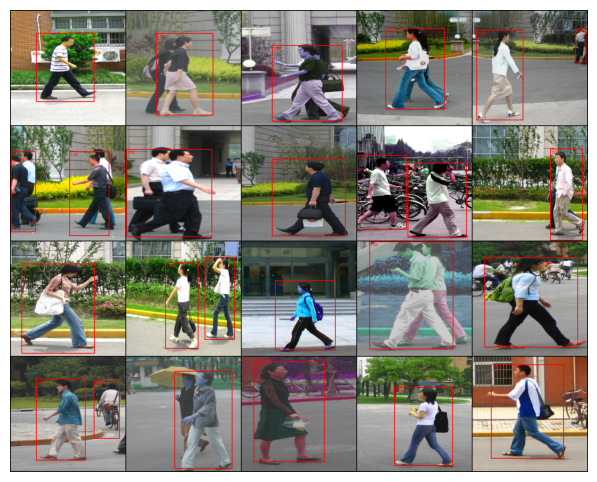

In [25]:
import torch
import torchvision.ops as ops
from torchvision.utils import draw_bounding_boxes, make_grid
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

model = SSD().to(device)
ckpt = torch.load("ssd_resnet34_pennfudan_best.pt", map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()
img_path = 'Test2.png'
img = read_image(img_path) / 255.0

imgs = []

for i in range(20):
    img, label = train_ds[i]

    img_uint8 = (img * 255).to(torch.uint8)  
    H, W = img.shape[1], img.shape[2]

    with torch.no_grad():
        x = img.unsqueeze(0).to(next(model.parameters()).device)
        t_pred, cls_logits, anchors_center, anchors_corner = model(x) 

        fg_scores = cls_logits.softmax(dim=-1)[0, :, 1]

        conf_thresh = 0.5
        keep = fg_scores > conf_thresh
        if keep.sum() == 0:
            keep = torch.zeros_like(fg_scores, dtype=torch.bool)
            keep[fg_scores.argmax()] = True

        scores = fg_scores[keep]
        a_sel  = anchors_center[keep]
        t_sel  = t_pred[0, keep]

        boxes_cxcywh = decoding(a_sel, t_sel)
        boxes_xyxy   = center_to_corner(boxes_cxcywh)

        scale = torch.tensor([W, H, W, H], device=boxes_xyxy.device, dtype=boxes_xyxy.dtype)
        boxes_xyxy = boxes_xyxy * scale

        boxes_xyxy[:, [0, 2]] = boxes_xyxy[:, [0, 2]].clamp(0, W - 1)
        boxes_xyxy[:, [1, 3]] = boxes_xyxy[:, [1, 3]].clamp(0, H - 1)

        iou_thresh = 0.45
        keep_nms = ops.nms(boxes_xyxy, scores, iou_thresh)

        boxes_xyxy = boxes_xyxy[keep_nms].cpu()
        scores     = scores[keep_nms].cpu()

        topk = 20
        if boxes_xyxy.shape[0] > topk:
            idx = scores.topk(topk).indices
            boxes_xyxy = boxes_xyxy[idx]
            scores     = scores[idx]

        img_uint8 = (img * 255).to(torch.uint8)
        labels = [f"{s.item():.2f}" for s in scores]
        out = draw_bounding_boxes(img_uint8, boxes_xyxy, colors="red", width=2, labels=labels)


        imgs.append(out)

grid = make_grid(imgs, nrow=5)
pil_grid = TF.to_pil_image(grid)

plt.figure(figsize=(10, 6))
plt.imshow(pil_grid)
plt.axis("off")
plt.show()